In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  **Data Preparation**

### Importing Libraries and Suppressing Warnings

In [2]:

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import os
import pandas as pd
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


2024-07-15 19:00:30.304080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 19:00:30.304208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 19:00:30.456658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting Dataset Paths and Loading Labels


In [3]:


# Set the path to the dataset
train_dir = '/kaggle/input/dog-breed-identification/train'
labels_file = '/kaggle/input/dog-breed-identification/labels.csv'

# Load the labels
labels_df = pd.read_csv(labels_file)


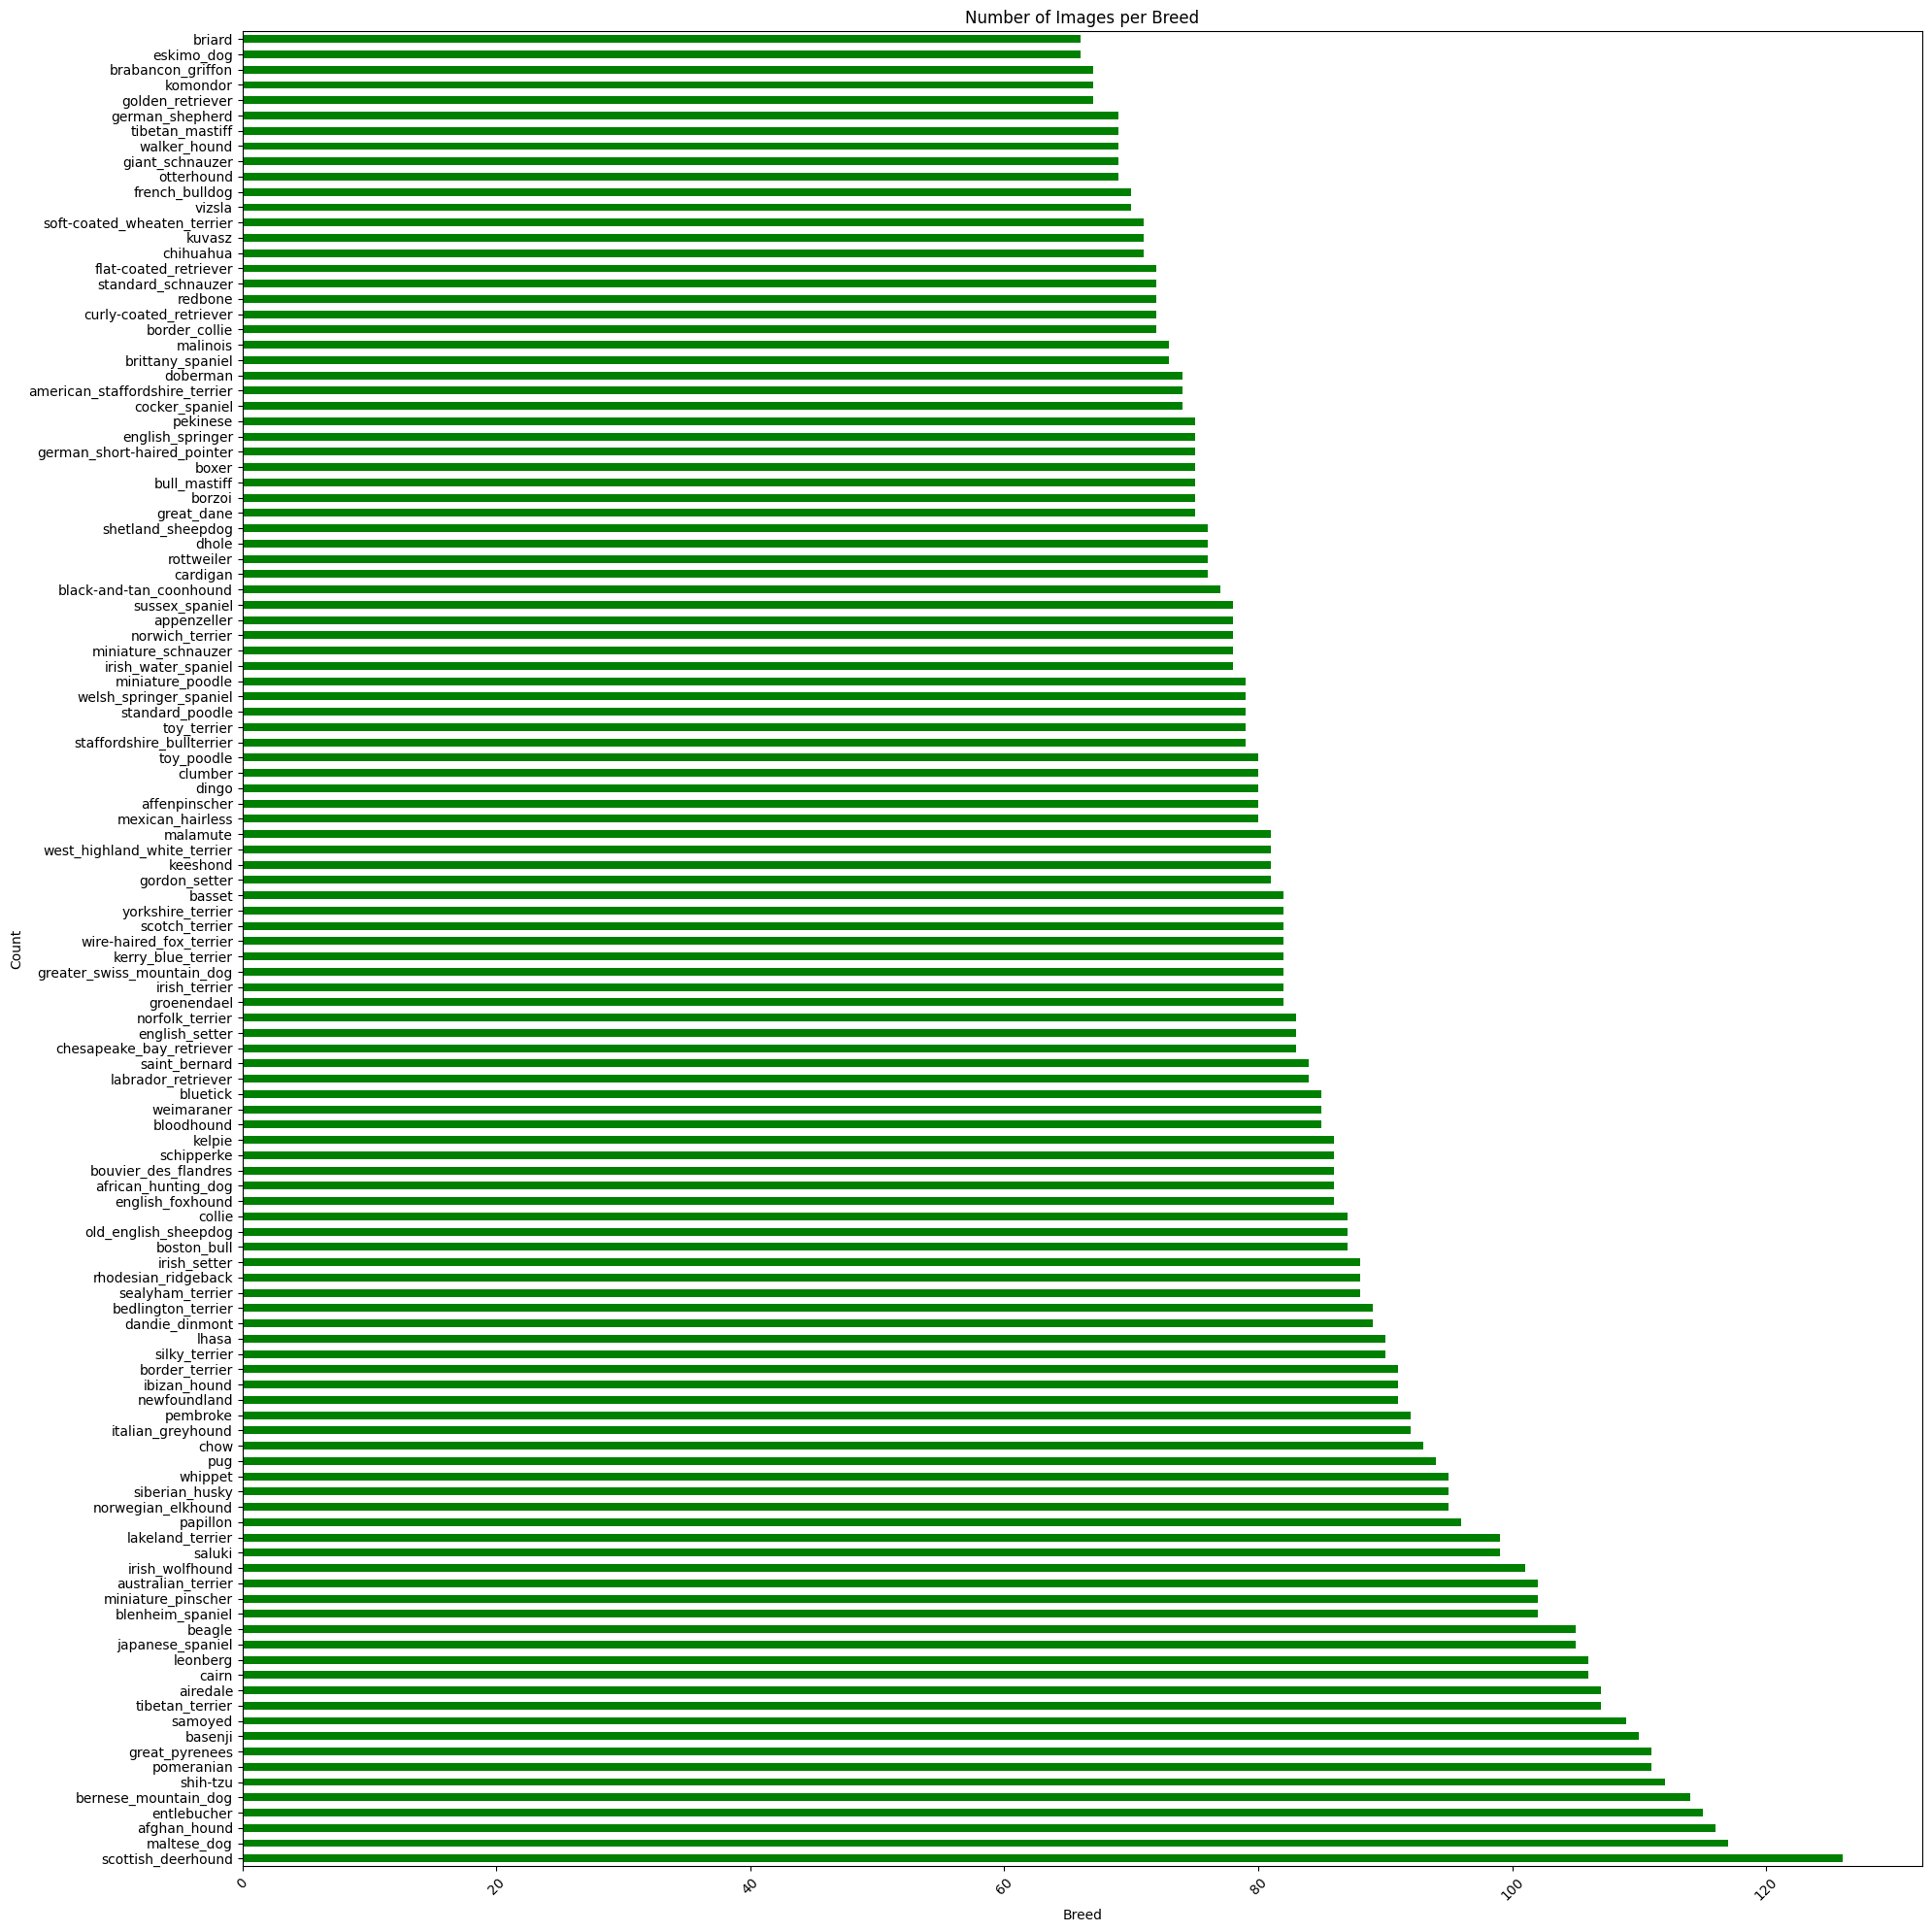

In [4]:
import matplotlib.pyplot as plt

# Count the number of images per breed
breed_counts = labels_df['breed'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(20, 20))
breed_counts.plot(kind='barh',color='g')
plt.title('Number of Images per Breed')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Filtering for Top 10 Breeds and Ensuring Image Count


In [5]:


# Filter for 10 breeds with 100 images each
selected_breeds = labels_df['breed'].value_counts().nlargest(10).index
filtered_labels_df = labels_df[labels_df['breed'].isin(selected_breeds)]

# Ensure each breed has exactly 100 images
filtered_labels_df = filtered_labels_df.groupby('breed').head(100)

filtered_labels_df['id'] = filtered_labels_df['id'] + '.jpg'


#### Selected Breeds

In [6]:
selected_breeds_list = filtered_labels_df['breed'].unique()
for breed in selected_breeds_list:
    print(breed)



basenji
scottish_deerhound
maltese_dog
shih-tzu
samoyed
entlebucher
bernese_mountain_dog
afghan_hound
great_pyrenees
pomeranian


####  Creating Directory for Filtered Images and Copying


In [7]:

# Create a directory for filtered images (in a temporary location)
filtered_images_dir = '/kaggle/working/filtered_images'
os.makedirs(filtered_images_dir, exist_ok=True)

# Copy the filtered images to the new directory
for img_name in filtered_labels_df['id']:
    src = os.path.join(train_dir, img_name)
    dst = os.path.join(filtered_images_dir, img_name)
    copyfile(src, dst)


#### Encoding Labels and Splitting Data


In [8]:


# Encode the labels
filtered_labels_df['breed'] = filtered_labels_df['breed'].astype('category')
filtered_labels_df['breed_code'] = filtered_labels_df['breed'].cat.codes
num_classes = filtered_labels_df['breed_code'].nunique()

# Split the data into training and validation sets
train_df, val_df = train_test_split(
    filtered_labels_df, 
    test_size=0.2, 
    stratify=filtered_labels_df['breed_code'],
    random_state=42
)


####  Data Augmentation and Image Loading


In [9]:
# Setting up ImageDataGenerator for Training and Validation
# Resize and normalize images with additional data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Add validation split here
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation split here


#### Generating Image Data for Training and Validation


In [10]:

# Load and preprocess images with smaller target size and batch size
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=filtered_images_dir,
    x_col='id',
    y_col='breed',
    subset='training',  # Use 'training' subset
    batch_size=16,  # Smaller batch size
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)  # Smaller target size
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=filtered_images_dir,
    x_col='id',
    y_col='breed',
    subset='validation',  # Use 'validation' subset
    batch_size=16,  # Smaller batch size
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)  # Smaller target size
)


Found 640 validated image filenames belonging to 10 classes.
Found 40 validated image filenames belonging to 10 classes.


#### Model Building and Training


In [11]:
# Loading Pre-trained Model and Adding Custom Layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top with dropout and L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increased L2 regularization
x = BatchNormalization()(x)  # Add batch normalization layer
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Compiling and Training the Model

In [12]:
# Unfreeze more layers of the base model
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping, learning rate scheduler, and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping, learning rate scheduler, and checkpointing
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Increased epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/50
 1/40 ━━━━━━━━━━━━━━━━━━━━ 41:24 64s/step - accuracy: 0.0625 - loss: 15.6956

I0000 00:00:1721070115.370936      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721070115.448853      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1159 - loss: 14.9511

W0000 00:00:1721070123.253542      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 321ms/step - accuracy: 0.1188 - loss: 14.9285 - val_accuracy: 0.6750 - val_loss: 12.5928 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.3756 - loss: 13.1811 - val_accuracy: 0.7000 - val_loss: 12.0979 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5247 - loss: 12.6283 - val_accuracy: 0.7000 - val_loss: 11.9336 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6700 - loss: 12.0862 - val_accuracy: 0.7750 - val_loss: 11.7650 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6968 - loss: 11.9116 - val_accuracy: 0.8000 - val_loss: 11.4990 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7643 - loss: 11.5377 - val_accuracy: 0.8750 - val_loss: 11.2248 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy

### Evaluation


In [13]:
# Evaluating the Model on Validation Data


# Evaluate the model
evaluation = model.evaluate(val_generator)
print(f'Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8344 - loss: 5.6932
Validation Loss: 5.6988043785095215, Validation Accuracy: 0.824999988079071


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


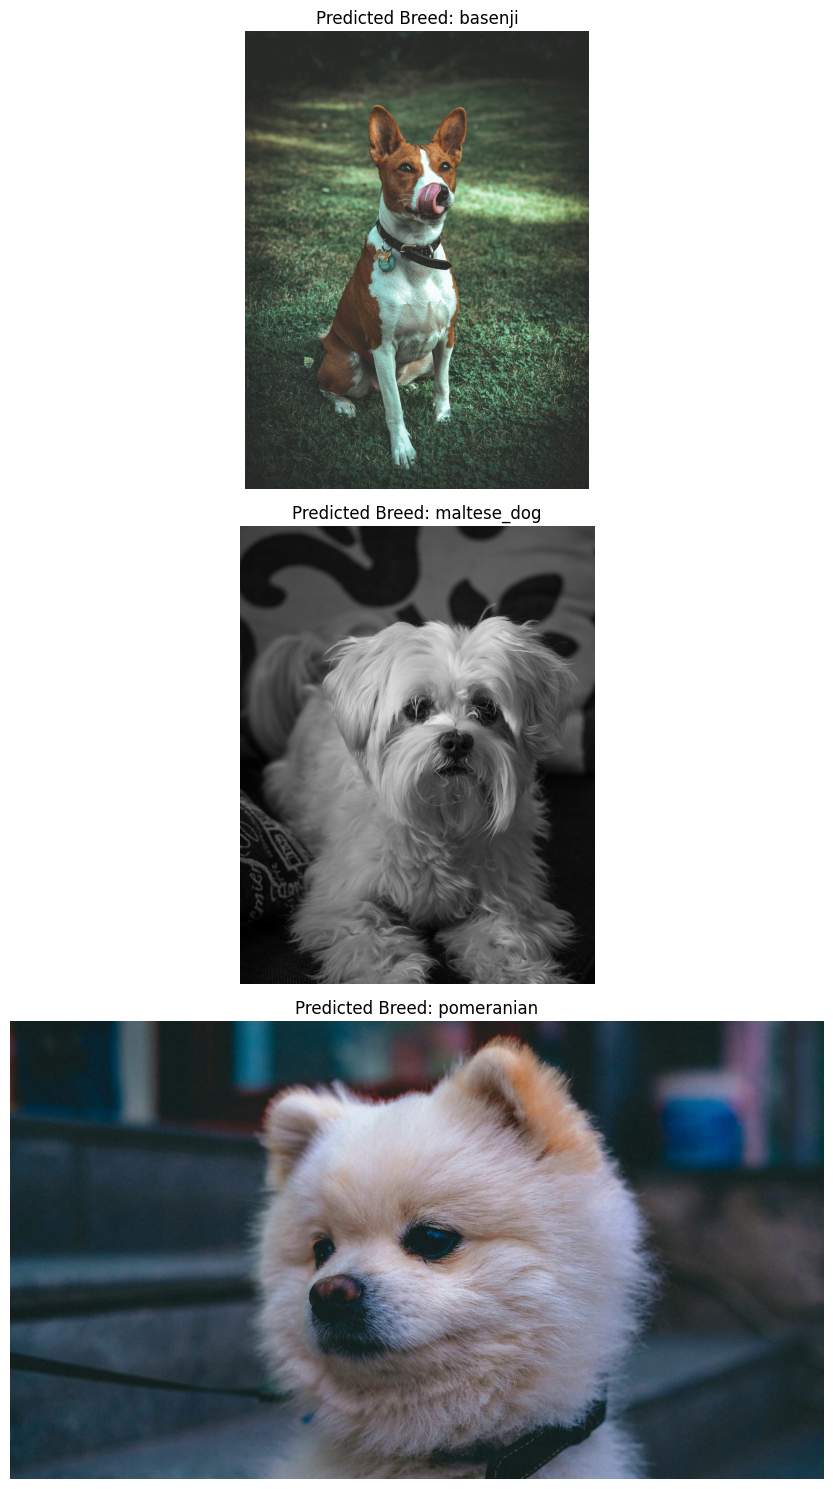

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Function to load the image without resizing
def load_original_image(img_path):
    img = image.load_img(img_path)
    return img

# Function to preprocess the image (resizing and normalization)
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img, img_array

# Assuming your model input size is 128x128
target_size = (128, 128)

# Paths to the images you want to predict
image_paths = [
    '/kaggle/input/dogs-breed/basenji.jpg',
    '/kaggle/input/dogs-breed/maltese.jpg',
    '/kaggle/input/dogs-breed/pomeranian.jpg'
]

# Load the trained model (if not already in memory)
# model = load_model('best_model.keras')  # Uncomment if you need to load the model from file

# Map the predicted class index to the corresponding breed
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}  # Reverse the dictionary

# Plot each image on a separate line with predicted breed
plt.figure(figsize=(10, 5 * len(image_paths)))

for i, img_path in enumerate(image_paths, 1):
    # Load the original image without resizing
    original_img = load_original_image(img_path)
    img, img_array = preprocess_image(img_path, target_size)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_breed = class_indices[predicted_class]
    
    plt.subplot(len(image_paths), 1, i)
    plt.imshow(original_img)
    plt.title(f'Predicted Breed: {predicted_breed}')
    plt.axis('off')

plt.tight_layout()
plt.show()
